# MNIST Handwritten Digits Recognition

## Importing the required packages

In [1]:
import numpy as np 
import torch 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

## Defining our Transform

In [2]:
transform=transforms.ToTensor()

## Gathering the train and test data

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

## Defining our train, validation and test dataloaders

In [5]:
valid_size=0.2
batch_size=20
num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [19]:
# This is for debugging
print(f"Train data size : {train_idx.__len__()}, Valdiation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")

Train data size : 48000, Valdiation data size : 12000, Test data size : 10000


In [20]:
# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

## Visualizing a Training batch

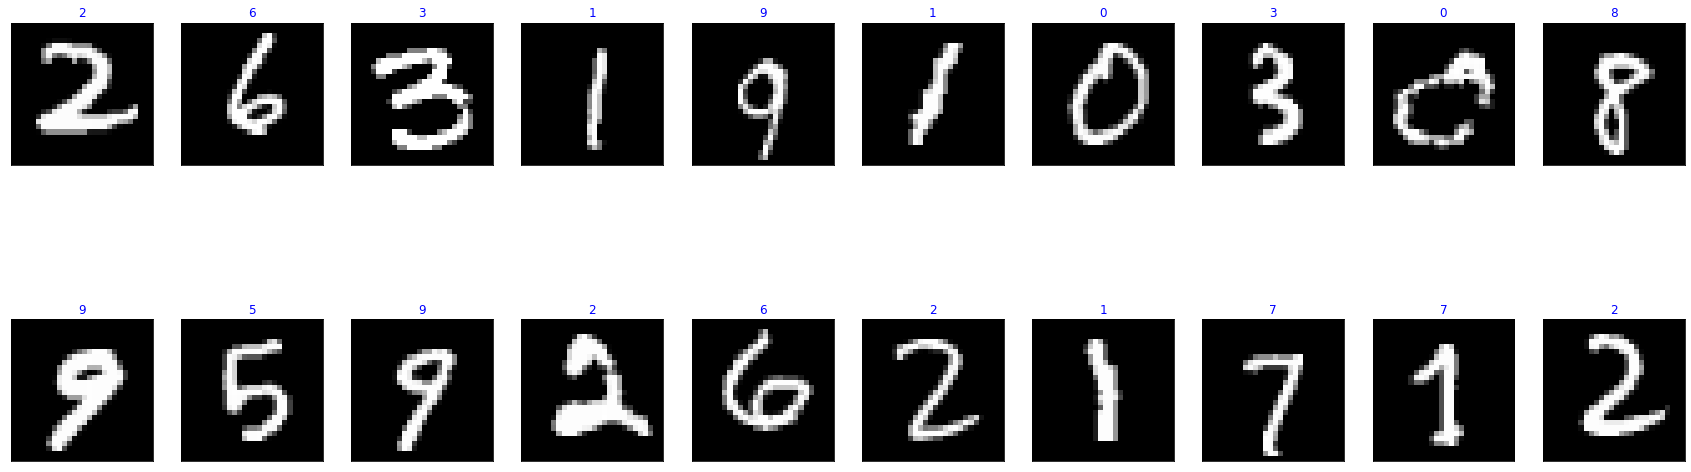

In [23]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]),cmap='gray')
    ax.set_title(labels[i].item(),color='blue')

## Defining Neural Net Architecture

In [28]:
"""
 This model has dropout set to a certain value
 NOTE : 
 When we want to use dropout we ensure we run .train() method on our model ---> during training phase
 If not required we should use .eval() method ---> during validation and testing phase
 """
class classicMNIST(nn.Module):
    def __init__(self):
        super(classicMNIST,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        # Flatten image
        x = x.view(-1, 28 * 28)        
        x=self.dropout(torch.sigmoid(self.fc1(x)))
        x=self.dropout(torch.sigmoid(self.fc2(x)))
        x=self.out(x)
        return x

In [30]:
model=classicMNIST()
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model.cuda()
print(f"Our Model : {model}, GPU Available : {torch.cuda.is_available()}")

Our Model : classicMNIST(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
), GPU Available : False


## Defining our Loss Function and Optimizer

In [32]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()

# Learning Rate
lr=0.001
# Optimizer 
optimizer=torch.optim.Adam(model.parameters(),lr=lr)

## Training and Validation Phase

In [33]:
# Number of epochs to train for
loss_keeper={'train':[],'valid':[]}
epochs=20

# minimum validation loss ----- set initial minimum to infinity
valid_loss_min = np.Inf 

for epoch in range(epochs):
  train_loss=0.0
  valid_loss=0.0

  """
  TRAINING PHASE
  """
  model.train() # TURN ON DROPOUT for training
  for images,labels in train_loader:
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    optimizer.zero_grad()
    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*images.size(0)

  """
  VALIDATION PHASE
  """
  model.eval() # TURN OFF DROPOUT for validation
  for images,labels in valid_loader:
    output=model(images)
    loss=criterion(output,labels)
    valid_loss+=loss.item()*images.size(0)

  # Calculating loss over entire batch size for every epoch
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)


  # saving loss values
  loss_keeper['train'].append(train_loss)
  loss_keeper['valid'].append(valid_loss)

  print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
  if valid_loss<=valid_loss_min:
    print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
    torch.save(model.state_dict(), 'model.pt')
    valid_loss_min=valid_loss



Epoch : 1	Training Loss : 0.3146997740554313	Validation Loss : 0.035799687116096414
Validation loss decreased from : inf ----> 0.035799687116096414 ----> Saving Model.......

Epoch : 2	Training Loss : 0.12625878515575703	Validation Loss : 0.02386306207285573
Validation loss decreased from : 0.035799687116096414 ----> 0.02386306207285573 ----> Saving Model.......

Epoch : 3	Training Loss : 0.08894360927057762	Validation Loss : 0.020760202920956847
Validation loss decreased from : 0.02386306207285573 ----> 0.020760202920956847 ----> Saving Model.......

Epoch : 4	Training Loss : 0.06466720153183754	Validation Loss : 0.018495641977953104
Validation loss decreased from : 0.020760202920956847 ----> 0.018495641977953104 ----> Saving Model.......

Epoch : 5	Training Loss : 0.05205725569724261	Validation Loss : 0.016274721628724363
Validation loss decreased from : 0.018495641977953104 ----> 0.016274721628724363 ----> Saving Model.......

Epoch : 6	Training Loss : 0.041456900798720504	Validati

## Loading model from Lowest Validation Loss

In [35]:
model.load_state_dict(torch.load('model.pt'))
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0233, -0.0124, -0.0200,  ...,  0.0228, -0.0166, -0.0144],
                      [-0.0228, -0.0302,  0.0080,  ...,  0.0317,  0.0222, -0.0232],
                      [ 0.0200, -0.0339,  0.0099,  ..., -0.0082,  0.0269, -0.0195],
                      ...,
                      [-0.0025, -0.0328, -0.0163,  ..., -0.0179, -0.0267, -0.0158],
                      [ 0.0352, -0.0134,  0.0059,  ..., -0.0150, -0.0256,  0.0256],
                      [-0.0191,  0.0065, -0.0162,  ..., -0.0175, -0.0027, -0.0346]])),
             ('fc1.bias',
              tensor([-1.7190e-01, -3.8071e-01, -6.4701e-02, -9.1687e-02, -3.4280e-02,
                      -2.3148e-02, -4.4069e-02, -9.0170e-02, -1.7387e-01, -2.2247e-01,
                      -2.5377e-02, -3.0180e-01, -1.4293e-01, -2.0479e-01,  1.1722e-02,
                      -2.0001e-01, -3.1332e-01, -2.7852e-02, -3.0991e-01, -3.6490e-02,
                       9.9112e-02, -9.2092e-02, -5.3883e-02,  1.

## Plotting Training and Validation Losses

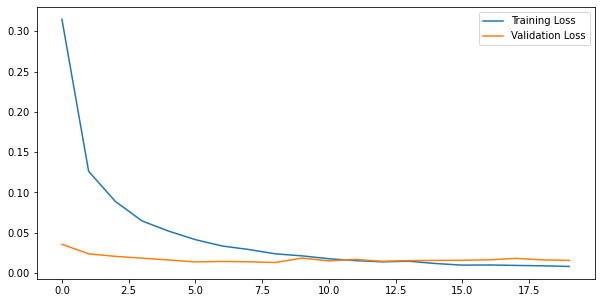

In [37]:
plt.figure(1,figsize=(10,5))
plt.plot(loss_keeper['train'],label="Training Loss")
plt.plot(loss_keeper['valid'],label="Validation Loss")
plt.legend();

## Testing Phase

In [39]:
correct=0
test_loss=0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # test the model with dropout layers off
for images,labels in test_loader:
    output=model(images)
    loss=criterion(output,labels)
    test_loss+=loss.item()*images.size(0)
    _,pred=torch.max(output,1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss=test_loss/len(train_loader.dataset)

print(f"Test Loss : {test_loss}")
print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {int(sum(class_correct))}")
print(f"Total Predictions per class : {class_total}, Total predictions to be made : {int(sum(class_total))}")

for i in range(10):
    if class_total[i] > 0:
        print(f"\nTest Accuracy of class {i} : {int(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
    else:
        print('\nTest Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print(f"\nOverall Test Accuracy : {int(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")

Test Loss : 0.011640305602460557
Correctly predicted per class : [972.0, 1125.0, 1012.0, 988.0, 960.0, 873.0, 933.0, 1001.0, 955.0, 985.0], Total correctly perdicted : 9804
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000

Test Accuracy of class 0 : 99% where 972 of 980 were predicted correctly

Test Accuracy of class 1 : 99% where 1125 of 1135 were predicted correctly

Test Accuracy of class 2 : 98% where 1012 of 1032 were predicted correctly

Test Accuracy of class 3 : 97% where 988 of 1010 were predicted correctly

Test Accuracy of class 4 : 97% where 960 of 982 were predicted correctly

Test Accuracy of class 5 : 97% where 873 of 892 were predicted correctly

Test Accuracy of class 6 : 97% where 933 of 958 were predicted correctly

Test Accuracy of class 7 : 97% where 1001 of 1028 were predicted correctly

Test Accuracy of class 8 : 98% where 955 of 974 were predicted correctly

Test Accu

## Visualizing a Test batch with results

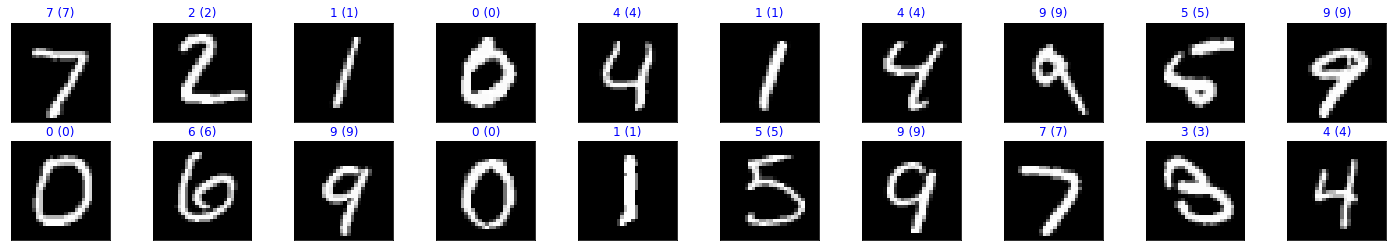

In [40]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("blue" if preds[idx]==labels[idx] else "red"))